In [ ]:
%pip install scikit-image

In [ ]:
import fitz
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.transform import resize
from imageio import imread

# Step 1: Convert the first page of a PDF to a PNG image using fitz
def convert_pdf_to_image(pdf_path, output_folder):
    doc = fitz.open(pdf_path)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    page = doc.load_page(1)  # Load the first page (index 0)
    pix = page.get_pixmap()
    image_path = os.path.join(output_folder, f"{pdf_path[9:20]}_page_1.png")
    pix.save(image_path)
    doc.close()
    return image_path

pdf_path = "porcones-test.pdf"
output_folder = "output_folder"
image_path = convert_pdf_to_image(pdf_path, output_folder)


4032 x 3024


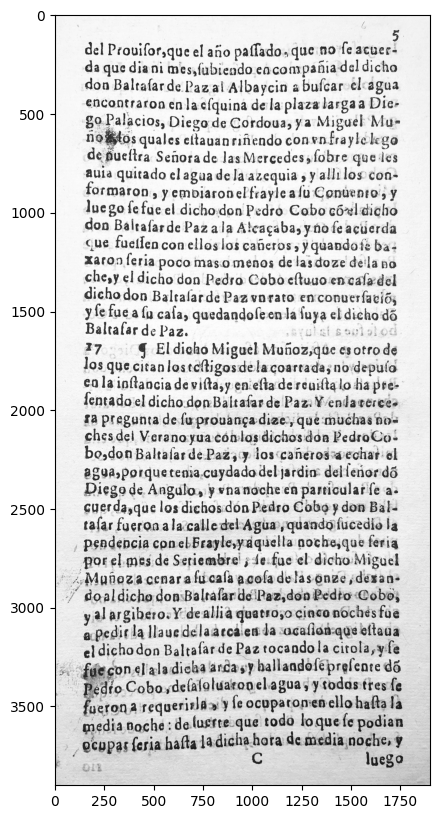

In [ ]:
from skimage.io import imread, imsave
from skimage.color import rgb2gray
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize

img = imread("/content/output_folder/VC.1018.42 _page_1.png")[:,:,:]

# img = resize(img, (511, 366))

print(f'{img.shape[0]} x {img.shape[1]}')

if img.ndim > 2: # is this is a rgb/rgba image
    img = rgb2gray(img)

plt.figure(figsize=(10,10))
# plt.axis("off")
plt.imshow(img, cmap="gray")
plt.show() # preview





### Find the Horizontal projection profile and find the window where line segment can be created.
One of the common ways of finding the line-height of a document is by analyzing its Horizontal projection profile.  Horizontal projection profile (HPP) is the array of sum or rows of a two dimentional image. Where there are more white spaces we see more peaks. These peaks give us an idea of where the segmentation between two lines can be done.

Before we run the project we should also threshold the image to clean all noise.

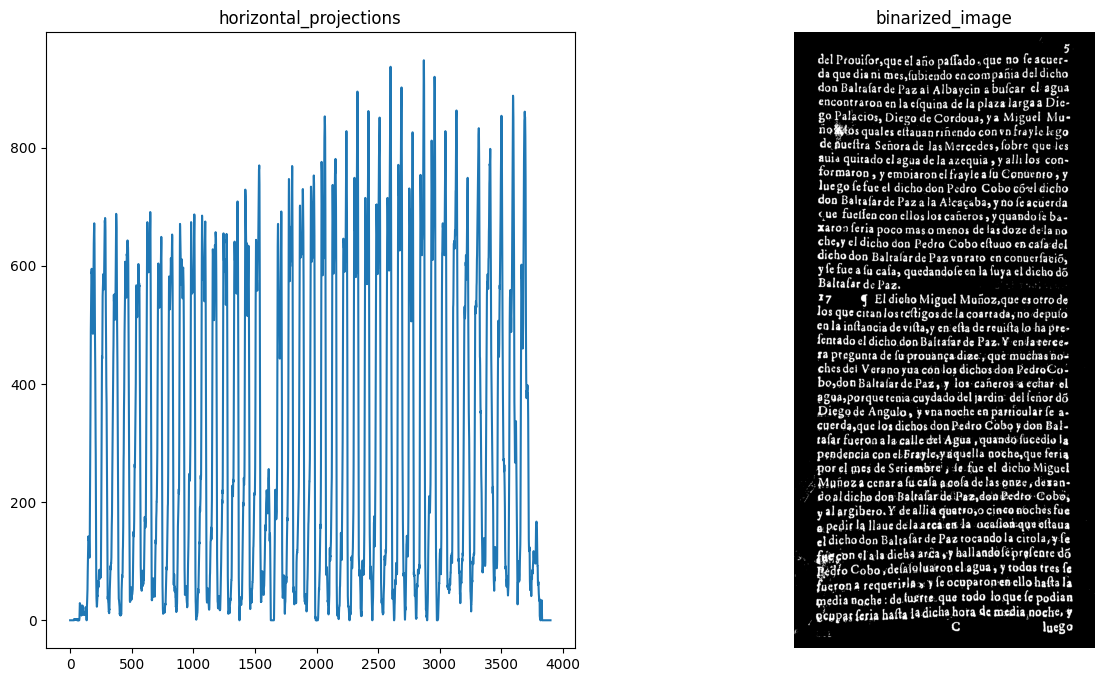

In [ ]:
from skimage.filters import threshold_otsu
import numpy as np

def horizontal_projections(sobel_image):
    return np.sum(sobel_image, axis=1)

def binarize_image(image):
    threshold = threshold_otsu(img)
    return image < threshold

binarized_image = binarize_image(img)
hpp = horizontal_projections(binarized_image)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax1.set_title("horizontal_projections")
ax1.plot(hpp)

ax2.axis("off")
ax2.set_title("binarized_image")
ax2.imshow(binarized_image, cmap="gray")

plt.show()

As you can see, where there were more white spaces there are peaks in the graph. We will use this information further to locate the regions where we can find the seperation line using the A* algorithm.

474.0


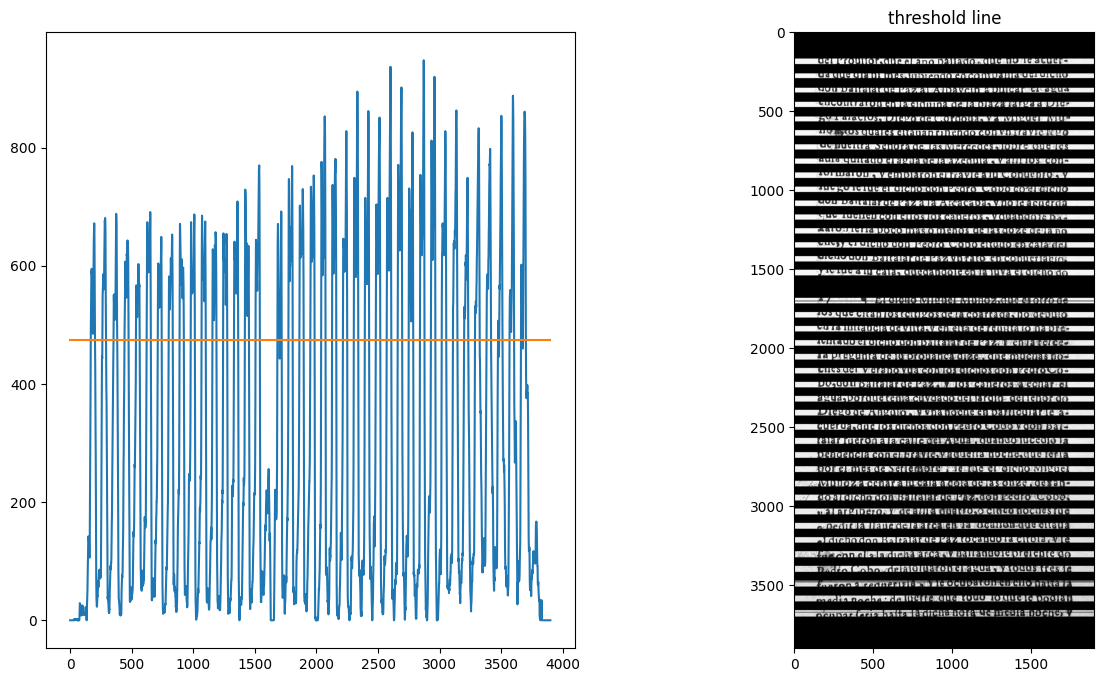

In [ ]:
# find the midway where we can make a threshold and extract the peaks regions
def find_peak_regions(hpp, threshold):

    peaks = []
    for i, hppv in enumerate(hpp):
        if hppv < threshold:
            peaks.append([i, hppv])
    return peaks

# find the threshold from where anything above is considered a peak region
# using the average for now but this needs further research.
# This may or may not work on all images.
threshold = (np.max(hpp)-np.min(hpp))/2

print(threshold)
peaks = find_peak_regions(hpp, threshold)

peaks_indexes = np.array(peaks)[:, 0].astype(int)

segmented_img = np.copy(img)
r, c = segmented_img.shape
for ri in range(r):
    if ri in peaks_indexes:
        segmented_img[ri, :] = 0

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax1.plot(hpp)
ax2.set_title("threshold line")
ax1.plot([0, img.shape[0]], [threshold, threshold,])
ax2.imshow(segmented_img, cmap="gray")
plt.show()


In [ ]:
from sklearn.cluster import KMeans

# Reshape the data for clustering
hpp_reshaped = hpp.reshape(-1, 1)

# Apply KMeans clustering with 2 clusters
kmeans = KMeans(n_clusters=2)
kmeans.fit(hpp_reshaped)

# Set the threshold between the two clusters
threshold = np.mean(kmeans.cluster_centers_)
threshold

352.47796466925524

In [ ]:
threshold = np.percentile(hpp, 66)  # Adjust percentile based on desired sensitivity
threshold

465.0

**The** threshold value helped us pick the probably white regions from the image.
The black regions indicate where we would need to run our path planning algorithm for line segmentation.

In [ ]:
# group the peaks through which we will be doing path planning.
diff_between_consec_numbers = np.diff(peaks_indexes) # difference between consecutive numbers
indexes_with_larger_diff = np.where(diff_between_consec_numbers > 1)[0].flatten()
peak_groups = np.split(peaks_indexes, indexes_with_larger_diff)
# remove very small regions, these are basically errors in algorithm because of our threshold value
peak_groups = [item for item in peak_groups if len(item) > 10]
print("peak groups found", len(peak_groups))

peak groups found 40


In [ ]:
# A star path planning algorithm
from heapq import *

def heuristic(a, b):
    return (b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2

def astar(array, start, goal):

    neighbors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    close_set = set()
    came_from = {}
    gscore = {start:0}
    fscore = {start:heuristic(start, goal)}
    oheap = []

    heappush(oheap, (fscore[start], start))

    while oheap:

        current = heappop(oheap)[1]

        if current == goal:
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j
            tentative_g_score = gscore[current] + heuristic(current, neighbor)
            if 0 <= neighbor[0] < array.shape[0]:
                if 0 <= neighbor[1] < array.shape[1]:
                    if array[neighbor[0]][neighbor[1]] == 1:
                        continue
                else:
                    # array bound y walls
                    continue
            else:
                # array bound x walls
                continue

            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue

            if  tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1]for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heappush(oheap, (fscore[neighbor], neighbor))

    return []

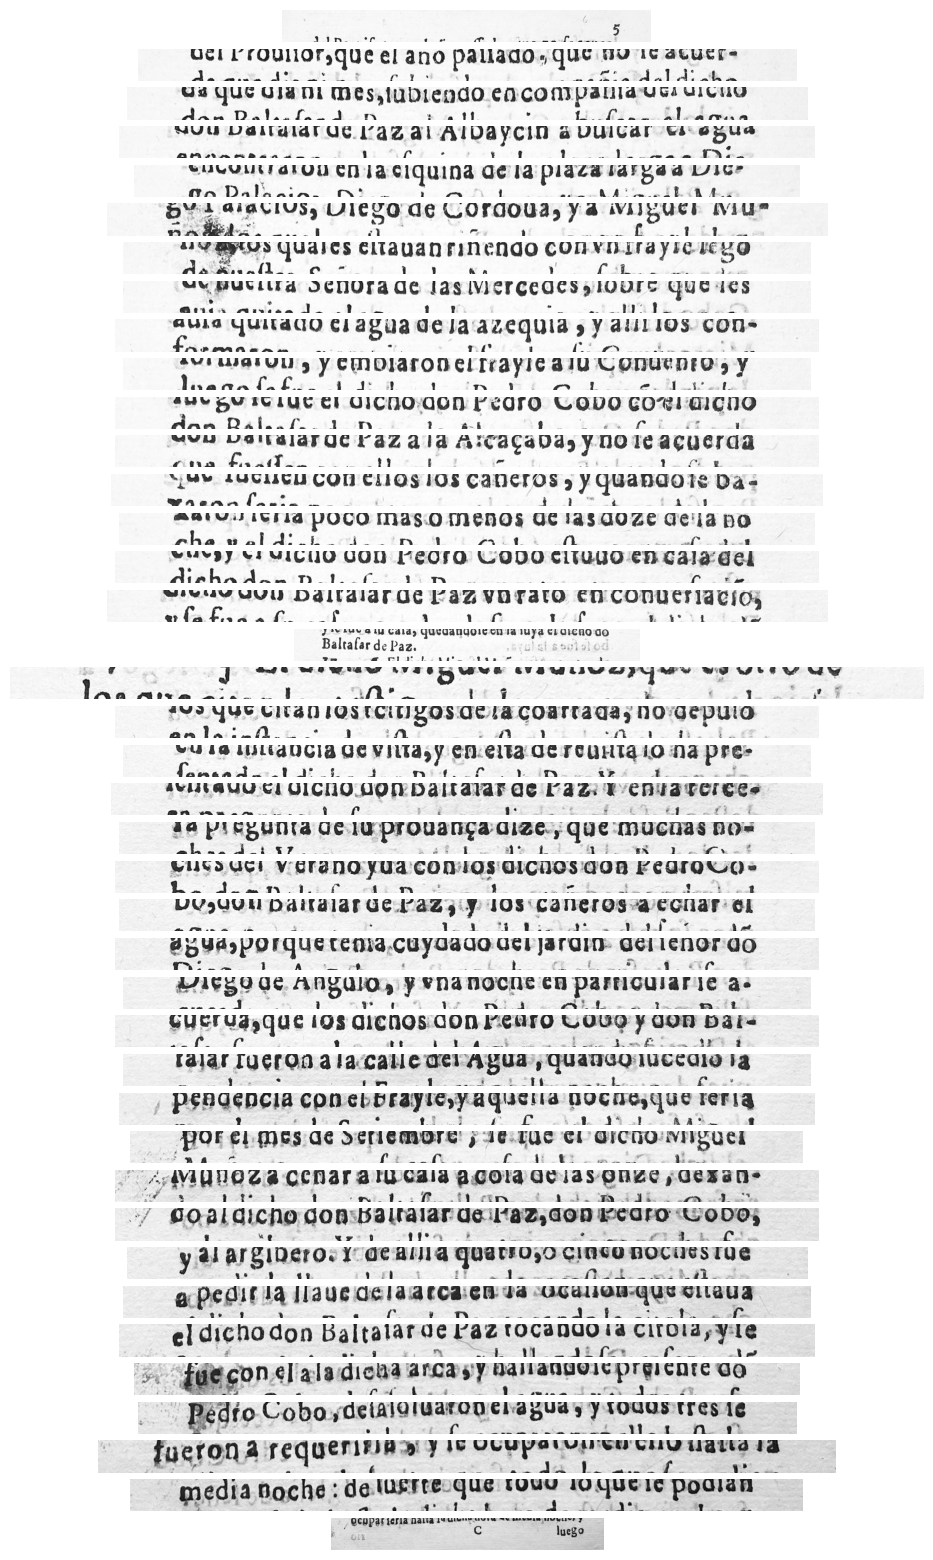

In [ ]:
# Visualize the peak images
fig, ax = plt.subplots(nrows=len(peak_groups), ncols=1, figsize=(15,20))
for index, sub_image_index in enumerate(peak_groups):
    sub_image = img[sub_image_index[0]:sub_image_index[-1]]
    ax[index].axis("off")
    ax[index].imshow(sub_image, cmap="gray")
plt.show()

In [ ]:
import numpy as np
from skimage.filters import threshold_otsu
from skimage.graph import route_through_array

def get_binary(img):
    mean = np.mean(img)
    if mean == 0.0 or mean == 1.0:
        return img

    thresh = threshold_otsu(img)
    binary = img <= thresh
    binary = binary.astype(np.uint8)  # Convert to uint8 for consistency
    return binary

binary_image = get_binary(img)
segment_separating_lines = []

for sub_image_index in peak_groups:
    start_row = sub_image_index[0]
    end_row = sub_image_index[-1]

    # Ensure start_row and end_row are within the bounds of the image
    start_row = max(0, start_row)
    end_row = min(binary_image.shape[0], end_row)

    # Extract the relevant portion of the binary image
    nmap = binary_image[start_row:end_row, :]

    # Define start and end points for A* algorithm
    start_point = (int(nmap.shape[0] / 2), 0)
    end_point = (int(nmap.shape[0] / 2), nmap.shape[1] - 1)

    # Find path using A* algorithm
    path, _ = route_through_array(nmap, start_point, end_point)

    # Add the offset to the path to get coordinates in the original image
    path = np.array(path) + start_row

    # Append the path to the list of segment separating lines
    segment_separating_lines.append(path)


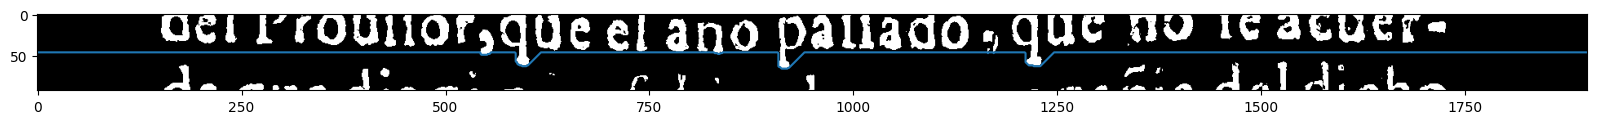

In [ ]:
# visualize a sample
cluster_of_interest = peak_groups[1]
offset_from_top = cluster_of_interest[0]
nmap = binary_image[cluster_of_interest[0]:cluster_of_interest[-1],:]
plt.figure(figsize=(20,20))
plt.imshow(nmap, cmap="gray")

path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2),nmap.shape[1]-1)))
plt.plot([x[1] for x in path], [x[0] for x in path])  # Extracting x and y coordinates separately

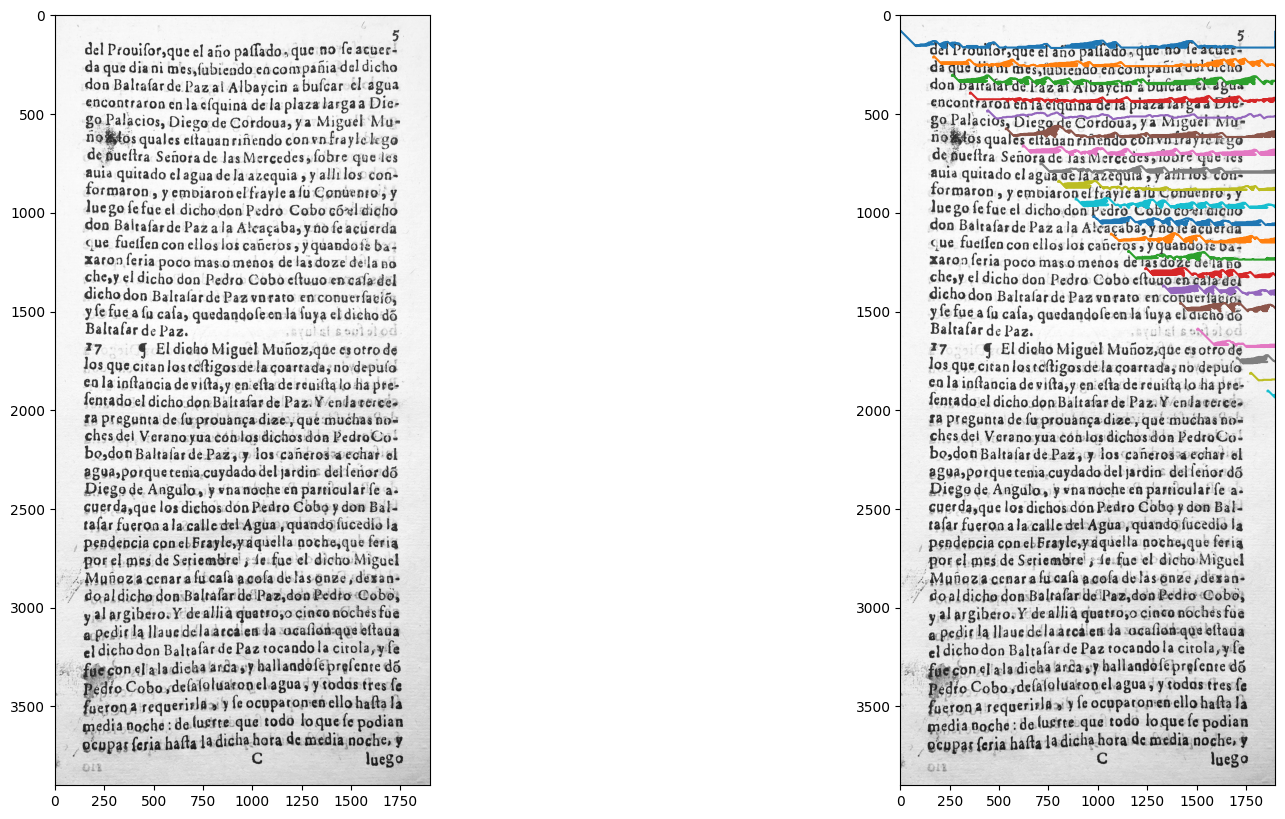

In [ ]:
offset_from_top = cluster_of_interest[0]
fig, ax = plt.subplots(figsize=(20,10), ncols=2)
for path in segment_separating_lines:
    ax[1].plot((path[:,1]), path[:,0])
ax[1].imshow(img, cmap="gray")
ax[0].imshow(img, cmap="gray")

### Lets divide the image now by the line segments passing through the image

(178, 1900)
(141, 1900)
(137, 1900)
(140, 1900)
(135, 1900)
(147, 1900)
(140, 1900)
(138, 1900)
(139, 1900)
(138, 1900)
(133, 1900)
(135, 1900)
(135, 1900)
(135, 1900)
(132, 1900)
(224, 1900)
split index 15
(182, 1900)
split index 16
(137, 1900)
(138, 1900)
(135, 1900)
(137, 1900)
(135, 1900)
(136, 1900)
(135, 1900)
(137, 1900)
(138, 1900)
(136, 1900)
(135, 1900)
(140, 1900)
(137, 1900)
(137, 1900)
(138, 1900)
(168, 1900)
(137, 1900)
(141, 1900)
(171, 1900)
(186, 1900)
split index 36
(137, 1900)
(288, 1900)
split index 38


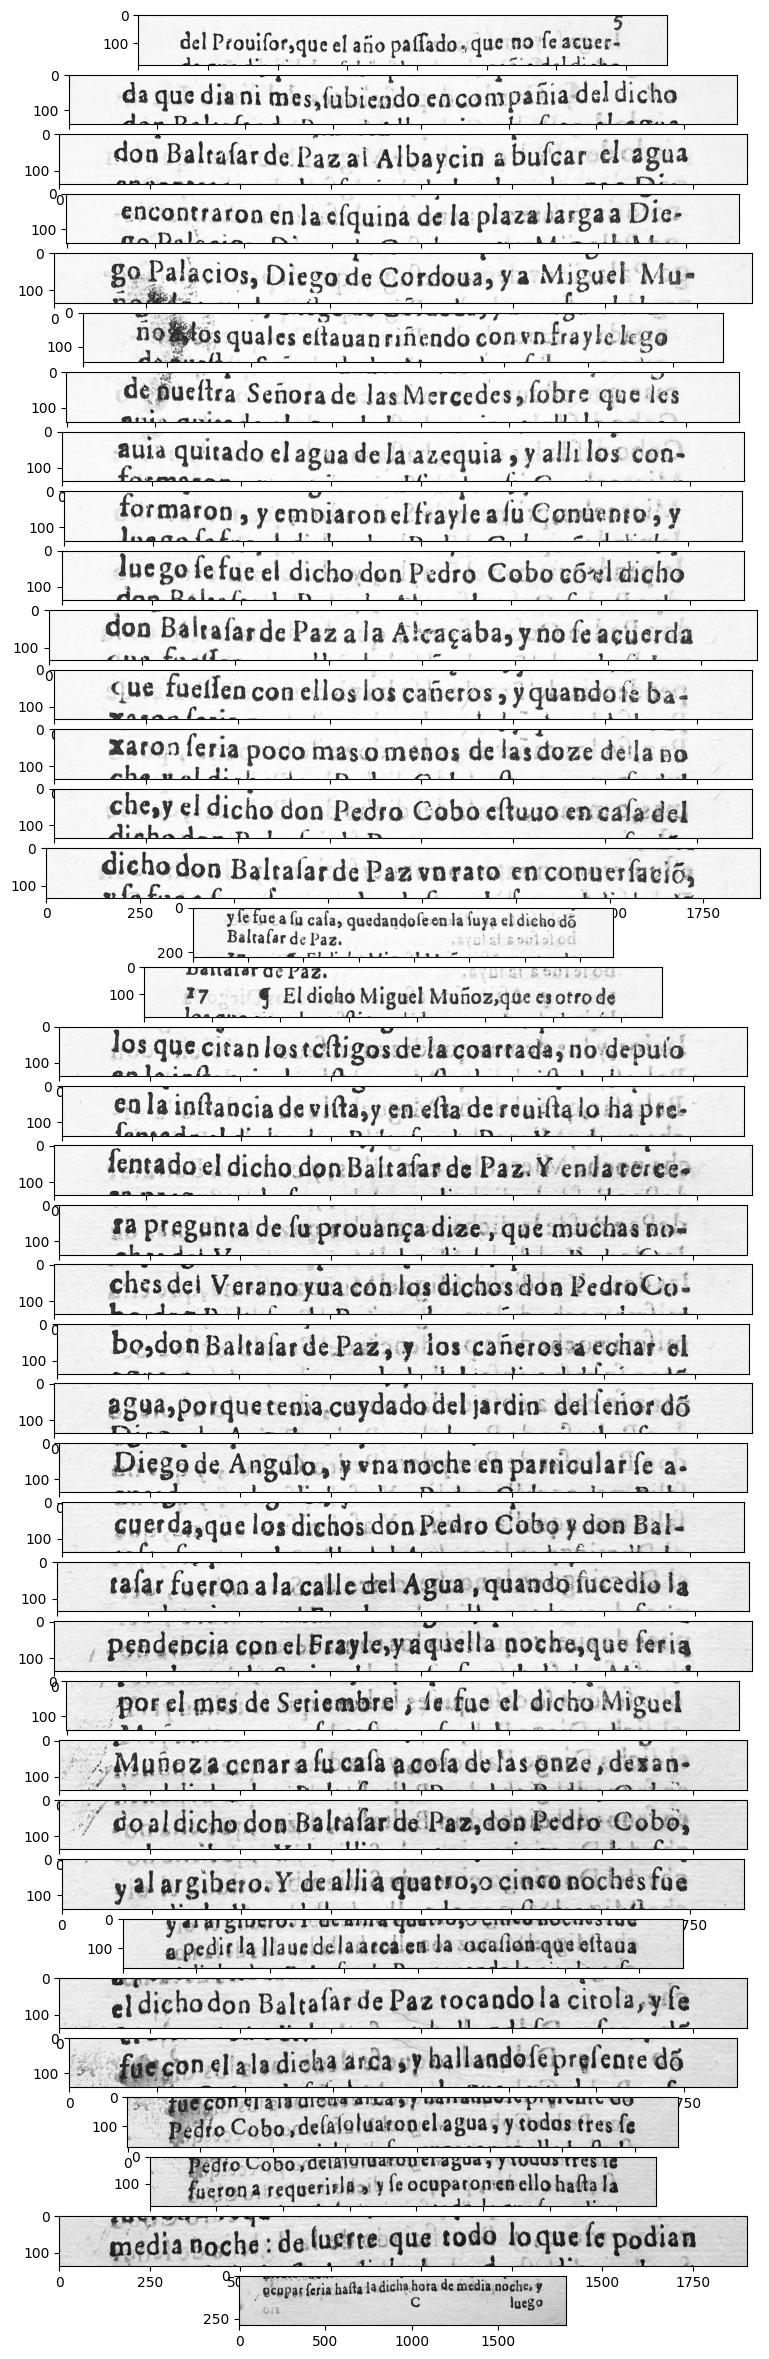

In [ ]:
seperated_images = []
for index, line_segments in enumerate(segment_separating_lines):
    if index < len(segment_separating_lines)-1:
        lower_line = np.min(segment_separating_lines[index][:,0])
        upper_line = np.max(segment_separating_lines[index+1][:,0])
        seperated_images.append(img[lower_line:upper_line])

image_heights = [line_image.shape[0] for line_image in seperated_images]
height_threshold = np.percentile(image_heights, 90)

# visualize it
fig, ax = plt.subplots(figsize=(30,30), nrows=len(seperated_images))
for index, line_image in enumerate(seperated_images):
    print(line_image.shape)
    if line_image.shape[0] > height_threshold:
        print(f"split index {index}")
    ax[index].imshow(line_image, cmap="gray")

plt.show()

In [ ]:
for index, line_image in enumerate(seperated_images):
    plt.imsave(f"/content/A/Porcones.png_line_{index+1}.png", line_image, cmap="gray")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# A star Line Segmentation Function

In [ ]:
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import threshold_otsu
import os
from skimage.graph import route_through_array
from heapq import heappush, heappop

def heuristic(a, b):
    """Calculate the squared distance between two points."""
    return (b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2

def get_binary(img):
    """Binarize the image using Otsu's threshold."""
    mean = np.mean(img)
    if mean == 0.0 or mean == 1.0:
        return img

    thresh = threshold_otsu(img)
    binary = img <= thresh
    binary = binary.astype(np.uint8)
    return binary

def astar(array, start, goal):
    """Perform A* algorithm to find a path from start to goal in a binary array."""
    neighbors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    close_set = set()
    came_from = {}
    gscore = {start:0}
    fscore = {start:heuristic(start, goal)}
    oheap = []

    heappush(oheap, (fscore[start], start))

    while oheap:
        current = heappop(oheap)[1]

        if current == goal:
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j
            tentative_g_score = gscore[current] + heuristic(current, neighbor)
            if 0 <= neighbor[0] < array.shape[0]:
                if 0 <= neighbor[1] < array.shape[1]:
                    if array[neighbor[0]][neighbor[1]] == 1:
                        continue
                else:
                    # array bound y walls
                    continue
            else:
                # array bound x walls
                continue

            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue

            if tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1] for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heappush(oheap, (fscore[neighbor], neighbor))

    return []

def preprocess_image(image_path,target_size):
    """Read and convert an image to grayscale."""
    try:
        img = imread(image_path)
        if target_size is not None:
            img = img[target_size[0]:target_size[1], target_size[2]:target_size[3],:]
        if img.ndim == 3 and img.shape[2] == 4:
            img = img[..., :3]
        if img.ndim > 2:
            img = rgb2gray(img)
        return img
    except FileNotFoundError:
        print(f"Error: File {image_path} not found.")
        return None

def horizontal_projections(sobel_image):
    """Calculate horizontal projections of the binary image."""
    return np.sum(sobel_image, axis=1)

def binarize_image(image):
    """Binarize an image using Otsu's threshold."""
    threshold = threshold_otsu(image)
    return image < threshold

def find_peak_regions(hpp, threshold):
    """Identify peak regions based on the horizontal projection profile."""
    peaks = []
    for i, hppv in enumerate(hpp):
        if hppv < threshold:
            peaks.append(i)
    return peaks

def line_segmentation(image_path, segmented_image_path, segmented_image_folder, threshold=None, min_peak_group_size = 10,target_size=None,ct=0, parent_line_num=None,recursive=False):
    """Segment an image into lines using horizontal projections and A*."""
    img = preprocess_image(image_path,target_size)
    if img is None:
        return

    binarized_image = binarize_image(img)
    hpp = horizontal_projections(binarized_image)

    if threshold == None:
      threshold = (np.max(hpp)-np.min(hpp))/2

    peaks = find_peak_regions(hpp, threshold)

    peaks_indexes = np.array(peaks).astype(int)

    segmented_img = np.copy(img)
    r, c = segmented_img.shape
    for ri in range(r):
        if ri in peaks_indexes:
            segmented_img[ri, :] = 0

    diff_between_consec_numbers = np.diff(peaks_indexes)
    indexes_with_larger_diff = np.where(diff_between_consec_numbers > 1)[0].flatten()
    peak_groups = np.split(peaks_indexes, indexes_with_larger_diff)
    peak_groups = [item for item in peak_groups if len(item) > min_peak_group_size]

    binary_image = get_binary(img)
    segment_separating_lines = []

    for sub_image_index in peak_groups:
        start_row = sub_image_index[0]
        end_row = sub_image_index[-1]

        start_row = max(0, start_row)
        end_row = min(binary_image.shape[0], end_row)

        nmap = binary_image[start_row:end_row, :]

        start_point = (int(nmap.shape[0] / 2), 0)
        end_point = (int(nmap.shape[0] / 2), nmap.shape[1] - 1)

        path, _ = route_through_array(nmap, start_point, end_point)

        path = np.array(path) + start_row

        segment_separating_lines.append(path)

    seperated_images = []

    for index, line_segments in enumerate(segment_separating_lines):
        if index < len(segment_separating_lines) - 1:
            lower_line = np.min(segment_separating_lines[index][:, 0])
            upper_line = np.max(segment_separating_lines[index + 1][:, 0])
            seperated_images.append(img[lower_line:upper_line])

    if not os.path.exists(segmented_image_folder):
        os.makedirs(segmented_image_folder)

    # Initialize count
    count = ct

    image_heights = [line_image.shape[0] for line_image in seperated_images]
    height_threshold = np.percentile(image_heights, 90)

    len_seperated_images = len(seperated_images)

    for index, line_image in enumerate(seperated_images):
        if parent_line_num is None:
            output_path = os.path.join(segmented_image_folder, f'{os.path.basename(segmented_image_path)}_line_{count + 1}.png')
        else:
            output_path = os.path.join(segmented_image_folder, f'{os.path.splitext(os.path.basename(segmented_image_path))[0]}_{count + 1}.png')
            if index < len(seperated_images) - 1:
              continue

        plt.imsave(output_path, line_image, cmap='gray')
        count += 1
        print(f"Saved line image to {output_path}")

        if line_image.shape[0] > height_threshold and not recursive:
            line_segmentation(output_path,output_path, segmented_image_folder,min_peak_group_size = 3 ,parent_line_num=f"{parent_line_num}_{count}" if parent_line_num else count,recursive=True)
            os.remove(output_path)
            print(f"Deleted line image {output_path}")
        elif recursive:
            return



In [ ]:
line_segmentation('/content/output_folder/VC.1018.42 _page_1.png','/content/output_folder/VC.1018.42 _page_1.png','/content/VC.1018.42_4')

Saved line image to /content/VC.1018.42_4/VC.1018.42 _page_1.png_line_1.png
Saved line image to /content/VC.1018.42_4/VC.1018.42 _page_1.png_line_2.png
Saved line image to /content/VC.1018.42_4/VC.1018.42 _page_1.png_line_3.png
Saved line image to /content/VC.1018.42_4/VC.1018.42 _page_1.png_line_4.png
Saved line image to /content/VC.1018.42_4/VC.1018.42 _page_1.png_line_5.png
Saved line image to /content/VC.1018.42_4/VC.1018.42 _page_1.png_line_6.png
Saved line image to /content/VC.1018.42_4/VC.1018.42 _page_1.png_line_7.png
Saved line image to /content/VC.1018.42_4/VC.1018.42 _page_1.png_line_8.png
Saved line image to /content/VC.1018.42_4/VC.1018.42 _page_1.png_line_9.png
Saved line image to /content/VC.1018.42_4/VC.1018.42 _page_1.png_line_10.png
Saved line image to /content/VC.1018.42_4/VC.1018.42 _page_1.png_line_11.png
Saved line image to /content/VC.1018.42_4/VC.1018.42 _page_1.png_line_12.png
Saved line image to /content/VC.1018.42_4/VC.1018.42 _page_1.png_line_13.png
Saved li

/content/Covarrubias - Tesoro lengua5/Covarrubias - Tesoro lengua_page_9.png_line_1.png: (25, 396, 3)
/content/Covarrubias - Tesoro lengua5/Covarrubias - Tesoro lengua_page_9.png_line_2.png: (16, 396, 3)
/content/Covarrubias - Tesoro lengua5/Covarrubias - Tesoro lengua_page_9.png_line_3.png: (17, 396, 3)
/content/Covarrubias - Tesoro lengua5/Covarrubias - Tesoro lengua_page_9.png_line_4.png: (17, 396, 3)
/content/Covarrubias - Tesoro lengua5/Covarrubias - Tesoro lengua_page_9.png_line_5.png: (15, 396, 3)
/content/Covarrubias - Tesoro lengua5/Covarrubias - Tesoro lengua_page_9.png_line_6.png: (16, 396, 3)
/content/Covarrubias - Tesoro lengua5/Covarrubias - Tesoro lengua_page_9.png_line_7.png: (13, 396, 3)
/content/Covarrubias - Tesoro lengua5/Covarrubias - Tesoro lengua_page_9.png_line_8.png: (13, 396, 3)
/content/Covarrubias - Tesoro lengua5/Covarrubias - Tesoro lengua_page_9.png_line_9.png: (16, 396, 3)
/content/Covarrubias - Tesoro lengua5/Covarrubias - Tesoro lengua_page_9.png_line_

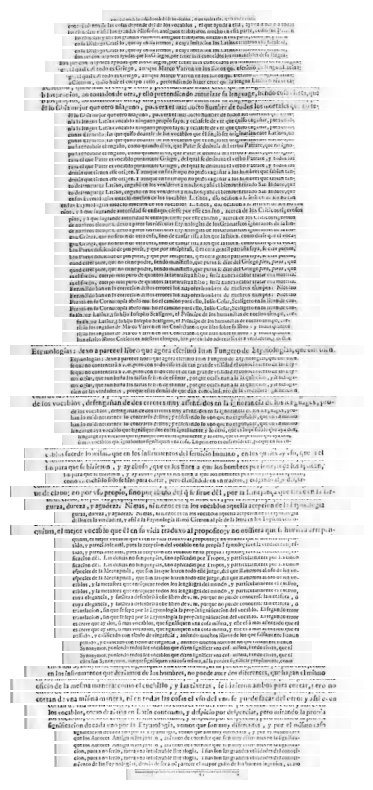

In [ ]:
import os
import re
import matplotlib.pyplot as plt
import cv2

def get_segmented_image_paths(input_path, segmented_image_dir):
    # Get the base name from the input path
    base_name = os.path.basename(input_path)

    # List all files in the directory
    files = os.listdir(segmented_image_dir)

    # Filter the files to get only those that start with the base name and end with "_line_*.png"
    segmented_files = [os.path.join(segmented_image_dir, f) for f in files if f.startswith(base_name) and "_line_" in f and f.endswith(".png")]

    return segmented_files

def extract_line_number(file_path):
    # Extract the line number(s) from the file name using regex
    match = re.search(r'_line_(\d+(_\d+)?).png$', file_path)
    if match:
        return list(map(int, match.group(1).split('_')))
    return [-1]

def sort_segmented_image_paths(image_paths):
    # Sort the list of paths based on the extracted line number
    sorted_paths = sorted(image_paths, key=extract_line_number)
    return sorted_paths

# Example usage
input_path = "/content/image_folder1/Covarrubias - Tesoro lengua_page_9.png"
segmented_image_dir = '/content/Covarrubias - Tesoro lengua5'

# Get sorted image paths
image_paths = get_segmented_image_paths(input_path, segmented_image_dir)
sorted_image_paths = sort_segmented_image_paths(image_paths)

# Read images from directory and store them in a list
seperated_images = []
for image_path in sorted_image_paths:
    image = cv2.imread(image_path)
    if image is not None:
        seperated_images.append(image)

# Create a subplot for each image and display them
fig, ax = plt.subplots(figsize=(10, 10), nrows=len(seperated_images))

for index, line_image in enumerate(seperated_images):
    print(f"{sorted_image_paths[index]}: {line_image.shape}")
    ax[index].imshow(line_image, cmap="gray")
    ax[index].axis('off')  # Hide axes

plt.show()
